# Analysis of multiple isotopic contrasts

In the use of neutron reflectometry, it is common to use multiple isotopic contrasts of experimental data to analyse a system in a constrained fashion. 
That is to say, that we have data from multiple different species (where isotopic substitution has been used to produce data with different scattering length density) that share the same structure. 
In this tutorial we will look at how `easyreflectometry` can be used to fit multiple contrasts of data from a [surfactant monolayer](./monolayer.rst) system, if you haven't looked at the tutorial for a single contrast of surfactant monolayer data it is suggested that you as this tutorial will build on it.

First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import easyreflectometry
import refnx
from easyreflectometry.data import load
from easyreflectometry.plot import plot
from easyreflectometry.sample import Material
from easyreflectometry.sample import SurfactantLayer
from easyreflectometry.sample import Layer
from easyreflectometry.sample import LayerAreaPerMolecule
from easyreflectometry.sample import Sample
from easyreflectometry.experiment import Model
from easyreflectometry.experiment import percentage_fhwm_resolution_function
from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.fitting import Fitter
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

easyreflectometry: 1.0.0
refnx: 0.1.45


## Reading in the experimental data

We load in three different isotopic contrast that are stored in a single `.ort` file. 
This `.ort` file uses the [mutliple data set syntax](https://github.com/reflectivity/file_format/blob/master/specification.md#multiple-data-sets) to indicate that different measurements are present in a single file. 

In [2]:
data = load('_static/multiple.ort')

We can plot the data and return the dimensions of the data to see the contrasts that are present. 

In [3]:
data.dims

()

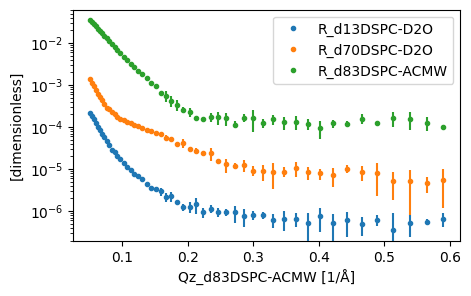

In [4]:
plot(data)

## Building our models

It can be seen above that there are three isotopic contrasts present in the `'multiple.ort'` file, namely:
- `'d13DSPC-D2O'`
- `'d70DSPC-D2O'`
- `'d83DSPC-ACMW'`

where, `'d13'` indicates that it is the head layer that is deuterated, `'d70'` indicates that the tail is deuterated and `'d83'` indicates the whole molecule is deuterated. 
We describe these different deuterations as chemical formulae below. 

In [5]:
dspc = {'d-head': 'C10D18NO8P', 'd-tail': 'C34D70',
        'h-head': 'C10H18NO8P', 'h-tail': 'C34H70'}

The solvent contrast is indicated as either D2O or ACMW (air-contrast matched water). 

In [6]:
d2o = Material(sld=6.36, isld=0, name='D2O')
acmw = Material(sld=0, isld=0, name='ACMW')

All of the contrasts are at the air/water interface, so we also need an `air` material.

In [7]:
air = Material(sld=0, isld=0, name='Air')

Then we can create all of the traditional layers that we will need. 

In [8]:
d2o_layer = Layer(material=d2o, thickness=0, roughness=3, name='D2O Subphase')
acmw_layer = Layer(material=acmw, thickness=0, roughness=3, name='D2O Subphase')
air_layer = Layer(material=air, thickness=0, roughness=0, name='Air Superphase')

The different isotopic contrasts of `SurfactantLayer` objects can also be created (all with the same structural parameters).

In [9]:
head_thickness = 12
tail_thickness = 20
head_solvent_fraction = 0.5
tail_solvent_fraction = 0.0
area_per_molecule = 45
roughness = 3

The `'d13DSPC-D2O'` surfactant layer 

In [10]:
tail_layer_d13d2o = LayerAreaPerMolecule(
    molecular_formula=dspc['h-tail'],
    thickness=tail_thickness,
    solvent=air,
    solvent_fraction=tail_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
head_layer_d13d2o = LayerAreaPerMolecule(
    molecular_formula=dspc['d-head'],
    thickness=head_thickness,
    solvent=d2o,
    solvent_fraction=head_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
d13d2o = SurfactantLayer(
    tail_layer=tail_layer_d13d2o,
    head_layer=head_layer_d13d2o
)
d13d2o.constrain_area_per_molecule = True
d13d2o.conformal_roughness = True
d13d2o.constrain_solvent_roughness(d2o_layer)

The `'d70DSPC-D2O'` surfactant layer 

In [11]:
tail_layer_d70d2o = LayerAreaPerMolecule(
    molecular_formula=dspc['d-tail'],
    thickness=tail_thickness,
    solvent=air,
    solvent_fraction=tail_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
head_layer_d70d2o = LayerAreaPerMolecule(
    molecular_formula=dspc['h-head'],
    thickness=head_thickness,
    solvent=d2o,
    solvent_fraction=head_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
d70d2o = SurfactantLayer(
    tail_layer=tail_layer_d70d2o,
    head_layer=head_layer_d70d2o
)
d70d2o.constrain_area_per_molecule = True
d70d2o.conformal_roughness = True
d70d2o.constrain_solvent_roughness(d2o_layer)

The `'d83DSPC-ACMW'` surfactant layer 

In [12]:
tail_layer_d83acmw = LayerAreaPerMolecule(
    molecular_formula=dspc['d-tail'],
    thickness=tail_thickness,
    solvent=air,
    solvent_fraction=tail_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
head_layer_d83acmw = LayerAreaPerMolecule(
    molecular_formula=dspc['d-head'],
    thickness=head_thickness,
    solvent=acmw,
    solvent_fraction=head_solvent_fraction,
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
d83acmw = SurfactantLayer(
    tail_layer=tail_layer_d83acmw,
    head_layer=head_layer_d83acmw
)
d83acmw.constrain_area_per_molecule = True
d83acmw.conformal_roughness = True
d83acmw.constrain_solvent_roughness(acmw_layer)

## Introducing constraints

Then to ensure that the structure (thicknesss, area per molecule, etc.) is kept the same between the different contrasts we constain these (`layer2` is the head layer and `layer1`, which the neutron are incident on first are the tail layer). 
The `constrain_multiple_contrast` method allows this, not that is it important that a chain of constraints is produced, one constraining the next. 

In [13]:
# These four lines should be removed in future
d70d2o.head_layer.area_per_molecule_parameter.enabled = True
d70d2o.tail_layer.area_per_molecule_parameter.enabled = True
d83acmw.head_layer.area_per_molecule_parameter.enabled = True
d83acmw.tail_layer.area_per_molecule_parameter.enabled = True

d70d2o.constain_multiple_contrast(d13d2o)
d83acmw.constain_multiple_contrast(d70d2o)

We can check this constraint as worked as follows.

In [14]:
d13d2o.head_layer.thickness.raw_value, d70d2o.head_layer.thickness.raw_value, d83acmw.head_layer.thickness.raw_value

(12.0, 12.0, 12.0)

In [15]:
d13d2o.head_layer.thickness.value = 10

In [16]:
d13d2o.head_layer.thickness.raw_value, d70d2o.head_layer.thickness.raw_value, d83acmw.head_layer.thickness.raw_value

(10.0, 10.0, 10.0)

Even through only as single value (that for the d13-DSPC head thickness) was changed, all three values changed. 

Having constructed each of the surfactant layer object and implemented the constraints, we can now build Samples and models. 

In [17]:
resolution_function = percentage_fhwm_resolution_function(5)

d13d2o_sample = Sample(air_layer, d13d2o, d2o_layer)
d70d2o_sample = Sample(air_layer, d70d2o, d2o_layer)
d83acmw_sample = Sample(air_layer, d83acmw, acmw_layer)
d13d2o_model = Model(
    sample=d13d2o_sample,
    scale=0.1,
    background=data['data']['R_d13DSPC-D2O'].values.min(),
    resolution_function=resolution_function
)
d70d2o_model = Model(
    sample=d70d2o_sample,
    scale=0.1,
    background=data['data']['R_d70DSPC-D2O'].values.min(),
    resolution_function=resolution_function
)
d83acmw_model = Model(
    sample=d83acmw_sample,
    scale=0.1,
    background=data['data']['R_d83DSPC-ACMW'].values.min(),
    resolution_function=resolution_function
)

## Setting varying parameters

For this analysis, we want the scale and background for each model to vary and then some of the structural parameters. 
Since the structural parameters are constrained, we only need to define the bounds once. 
In the case on the `d13d2o` object, as this is the basis for the constraints. 

In [18]:
d13d2o_model.scale.bounds = (0.05, 1.5)
d13d2o_model.background.bounds = (4e-8, 1e-5)
d70d2o_model.scale.bounds = (0.05, 1.5)
d70d2o_model.background.bounds = (4e-8, 1e-5)
d83acmw_model.scale.bounds = (0.05, 1.5)
d83acmw_model.background.bounds = (4e-8, 1e-5)

d13d2o.tail_layer.area_per_molecule_parameter.bounds = (40, 50)
d13d2o.head_layer.solvent_fraction_parameter.bounds = (0.2, 0.6)
d13d2o.tail_layer.thickness.bounds = (18, 24)
d13d2o.head_layer.thickness.bounds = (8, 12)

## Creating interfaces and performing the fitting

The model has been created and the parameters defined, so the fitting process can begin. 
First, we should create a unique interface for each of the models. 

In [19]:
d13d2o_model.interface = CalculatorFactory()
d70d2o_model.interface = CalculatorFactory()
d83acmw_model.interface = CalculatorFactory()

The models and the interface fit functions are then passed to the `Fitter` object, which is capable of performed the multiple dataset fitting process.

In [20]:
f = Fitter(d13d2o_model, d70d2o_model, d83acmw_model)

In [21]:
analysed = f.fit(data)

Once the fitting is complete, we can probe a given value to check that the constraints have been respected or plot the results.

In [22]:
d13d2o.head_layer.area_per_molecule, d70d2o.head_layer.area_per_molecule, d83acmw.head_layer.area_per_molecule

(44.51664709456701, 44.51664709456701, 44.51664709456701)

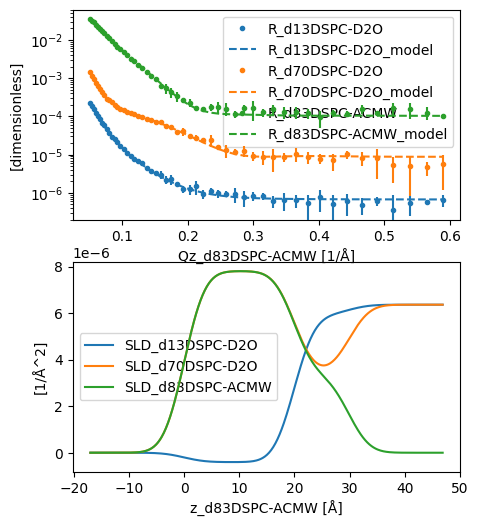

In [23]:
plot(analysed)